# Code Overview and Troubleshooting 

## Table of Contents

### Goals of this document 

### Paper Overview 

### Code Methodology 

### Code Walkthrough 

### Troubleshooting and Debugging 

### Goals of this document 

* What: The purpose of this document is to succintly explain the code and related methodology in "Ligand Strain Energy in Large Library Docking" in a coherent and straightforward manner to support our usage of this strain methodology in our virtual screening work. 

* Why: At the present moment, it is difficult to trust the use of this code because of several factors:

1. No native support for SDF files. 

The code has native support for the use of mol2 or db2 file types, but not sdf. In theory, this should not be an issue. The primary difference between mol2 and sdf is typically the ability to have partial charge information (in the mol2 file type). In theory, their calculation of torsion strain does not rely on anything but the atom types involved in the dihedral angle being analyzed and their 3D coordinates. However, practically, there are issues. I can't succinctly describe them as I am still trying to better understand the code. At a high level, the issue has to do with file conversions. Considering that the output of our VS is typically sdf, we either need to convert our sdf to mol2 and use the native function, or develop an equivalent function to their mol2/db2 input function that will take a native sdf file. 

What I have noticed here, is that neither approach can perfectly recreate the example output csv of torsion energies. This is complicated by the fact that there are only 3 example molecules given by the authors, which limits how throughly one could test the results of troubleshooting this problem. I will cover both approaches and the nuances.

2. Full understanding of the code. 

While I can explain at a high level what the code does, debug various aspects of it, refactor various components, and so on, the logic involved in selecting the torsion is difficult to follow. If I had a strong fundamental understanding of the code, it would be easier to understand. Ideally, this document will serve other members of our group well that could troubleshoot this code, without having to repeat the work I've done. 

* How: This document will first go through the methodology written in the paper, as well as the code provided to future users and attempt to succinctly explain how it works. This will be followed by the debugging section, in which I show what attempts I have made towards the file conversion issue. 

### Paper Methodology Overview:

This paper seeks to create an energy profile for a given conformer based on comparison of it's torsions to a pre-computed library of torsion energies.

The authors first describe the torsion library:

`Torsion Library Generation
We represent every sequence of four atoms defining a dihedral angle by a torsion pattern using the SMARTS line notation. (30) We adapted the torsion library of Rarey et al. (24,25) to build our own library, which has 514 torsion patterns with the same hierarchical organization as the original. Each torsion pattern has a histogram of the observed counts for each possible dihedral angle measurement in the CSD and PDB. For each torsion pattern’s histogram, if the total count is less than 100, we use an approximate approach. The original torsion library allows “tolerances” about each peak in the histogram, where the observed frequency drops below a certain value. Our approximate approach flags any degree difference between a conformation’s dihedral angle and the histogram’s peak that is larger than the maximum tolerance in the original library. If the total count is larger than 100, we convert the histogram frequencies into torsion energy units (TEUs) by applying the Boltzmann equation (Figure S1), which we term the “exact approach”. To avoid infinite energies from zero counts in the histograms, we add the minimum positive count from each histogram to any zero counts. We assume that the original measurements from the CSD and PDB exist in a canonical ensemble at 298 K, meaning the temperature of the hypothetical ensemble is a tunable parameter in creating the strain energy library. We therefore use TEU instead of kcal/mol to reflect the fact that our energy scale is artificial and based on the databases’ sampling of the hypothetical ensemble. We modeled this unit on Rosetta’s use of Rosetta energy units in its scoring function for protein structure conformational energy. (32,33)`

So far, this is mostly straightfoward. They are computing the 'torsion energy units' of a given 'torsion pattern' based on how often they have been observed in the CSD/PDB. The basic logic (as I understand) is: if the torsion found in your molecule is observed often in the crystallographic datasets, it is assumed to be lower in energy. If it not observed often, it is likely higher in energy. There are two ways that the energy is actually calculated, as either "exact" or "approximate". If observations ('total counts') are large (this pattern has been seen >100 times), they use an exacty method via the Boltzmann equation. If it is not observed very often, they use an "approximate" approach. Both calculation methods are in the code itself, so we'll cover how this works there. 

This part of the code and paper does not seem to be involved in the issues I am having, but it is worth describing to better understand what's going on. 

Then, this library is used like so: 

`
The current version can handle two types of input files: mol2 and db2 (a format for DOCK3.7). (34) With the energy profile for each torsion pattern precalculated in the library, we only need to look up the energy estimates for the torsion patterns present in the molecule and not calculate them from scratch. Using the Chem submodule in the Python module RDKit, (35) we find all of the torsion patterns present in the molecule based on their SMARTS patterns, calculate their dihedral angles, and then extract the relevant energy estimates from the torsion library. We keep the information matching the most specific (least general) torsion pattern in the library’s hierarchy. Then, we can sum the energy estimates for all of the torsion patterns to get the estimate for the molecule’s conformation or simply find the torsion patterns with energy estimates above the desired cutoff (Figure 1).`

This part of the methodology is where I think the issues arise. The methods here are not very descriptive beyond saying: (1) SMARTs patterns define the torsion pattern, (2) we get the torsion energies for these patterns, (3) we keep the information matching the most specific torsion pattern, (4) we can sum the energies of all the torsion patterns together. This is shown in Figure 1. 

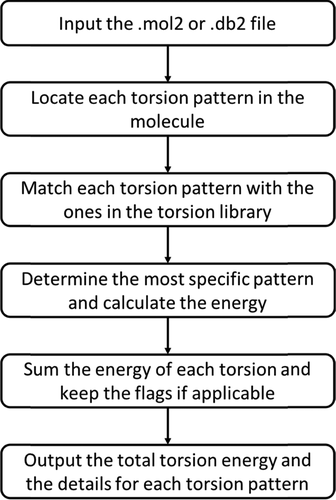

The issue here is that the actual python code that handles keeping the torsions is more complex than this. 



### Code Methodology 

#### Relevant Files

The relevant section of the code/data we need are in three parts: 

`TL_2.1_VERSION_6.xml`

This is the xml file containing the torsion patterns. We will examine this as it is relevant to how the code functions, specifically we are interested in how this xml is traversed because it will set a variable that is used to select one torsion pattern over another. 

`Torsion_Strain.py`

This is the 'executable' part of the code. It reads in functions that are in `TL_functions.py` and uses them to write a csv. There isn't a huge amount of logic in this actual code beyond writing the CSV itself. We will go through this. 

`TL_functions.py` 

This is difficult part of the code. To me, the most confusing aspect of this code has to do how torsion patterns are "filtered" so they can be reported in `Torsion_Strain.py`

#### Workflow 

At a high level, the code works like this. `Torsion_Strain.py` calls `TL_Functions.py` in order to get the data to write the csv using the `TL_lookup(mol)` function. `TL_lookup(mol)` returns a `TP_list` class. This class contains the data that is reported for a given molecule when `Torsion_Strain.py` writes the csv.

`TL_lookup(mol)` calls other functions in `TL_Functions.py`, notably `tp_match(tp, hc, j, mol, pos, bi)`. This part of the code is also challenging. The other functions are relatively straightforward and handle cancluating angles, normalizing values, and so on. 

We will walk through what happens to a molecule when it is passed into TL_lookup() to give us our output CSV. 

#### Walkthrough 



1. CSV Generation: 

The csv is written like this in `Torsion_Strain.py` (direct quote, original comments)

```py

file_name = output_name + "_Torsion_Strain.csv"
with open(file_name, mode = "w") as file_out:
    # Initialize the output file
    file_writer = csv.writer(file_out) #Initialize writing with csv, using
    # https://realpython.com/python-csv/ as a guide
    count = 0
    for name in names: #Loop over every molecule in the list
        mol = ms[name] #Get the molecule with that name
        if mol is not None: #Check to make sure the molecule exists
            try:
                M = TL_lookup(mol) #Create a TP_list function
                mol_est = []
                mol_est += M.sum(0)
                mol_info = M.get_TPs() #The molecule's information
                bond_info = [item for sublist in sorted(mol_info, key = lambda l:l[1], reverse=True) for item in sublist]
                # Unlist the list of lists into just a list of elements
                file_writer.writerow([name] + mol_est + bond_info)
                # Add the list as a row
            except:
                count += 1
                file_writer.writerow([name] + ["NA"])
    file_out.close()

```

This is pretty straightforward. At the try statement, we create `M` a `TP_list` object. We start a list called `mol_est`, we sum the energies (this sum function is specific to this class, not a generic python function). We use the `get_TPs()` method to get the information for a subset of torsion patterns and save it as mol_info. We flatten that mol_info in the next line, `bond_info`.

The `bond_info` variable works like so: It flattens `mol_info` into a single list `bond_info`, sorting the sublists in `mol_info` in descending order based on their second element. This how we get the output we see in the CSV. Then we write the name, the sum of energies (mol_est) and torsion pattern information to a line in the csv and we continue to the next mol object.

From here we can see that `TL_lookup(mol)` creates a `TP_list` class, that has functions `.sum()` (total energy) and `.get_TPs()` (information about the torsion pattern). This is ultimately what gives you the data for a given mol. Both `.sum()` and `get_TPs()` are complex functions but neither governs the logic of which torsion patters are kept, which is the discrepency I am seeing, so I will skip over them for now. 

We'll start instead at `TL_lookup()`. It's a long function, and it will call `tp_match()`, so we'll do it in parts. 

```py 

def TL_lookup(mol): #mol is read in from the .mol2 file
    positions = mol.GetConformer().GetPositions()
    # List of lists of atom coordinates. Luckily RDKit starts indexing at 0
    bond_info = []
    # Initialize an empty list that will hold the information for each bond
    i = 0 #Initialize count of torsion rules

    # Loop over all of the specific hierarchy classes
    for HC in root.findall("hierarchyClass"):
        if HC.get("name") != "GG": #Not the general class
            for TP in HC.iter("torsionRule"): #Loop over each torsion rules
                tp_match(TP, "specific", i, mol, positions, bond_info)
                i += 1 #Increase the count for the torsion rule

    # Now for the general method:
    for TP in root.find("hierarchyClass[@name='GG']").iter("torsionRule"):
        tp_match(TP, "general", i, mol, positions, bond_info)
        i += 1 #Increase the count for the torsion rule

```

First we get the positions of our rdkit mol object using rdkit functions `mol.GetConformer().GetPositions()`. We make any empty `bond_info` list. We make a counter, `i`, to count the torsion rules. We then loop through the xml, we start with the not GG types of torsions in the xml (not the general classes). We loop through the torsionRules, which are smarts patterns. Here's what that can look like in the xml. 

```xml 

<hierarchyClass id1="C" id2="O" name="CO">
    <hierarchySubClass name="Ester bond I" smarts="O=[C:2][O:3]">
      <torsionRule method="exact" smarts="[O:1]=[C:2]!@[O:3]~[CH0:4]">

```

Here 'name' is "CO". The torsionRule has the calculation method (exact or approximate) and the smarts pattern for that torsion. We call tp_match on every torsion rule. After we do so, we will increment `i` so that we can keep track of how far we've searched, which will be important for filtering torsions.

We will then call tp_match() for the general torsions in a very similar way. The only change is that we will use "general" as an argument here, whilwe used specific the first time. This is to keep track of whether or torsion is associated with a "specific" or a "general" match. Here's an example of a general torsion. 

```xml
<library>
  <hierarchyClass id1="G" id2="G" name="GG">
    <torsionRule method="exact" smarts="[*:1]~[CX4:2]!@[n:3]~[*:4]">
```

Note that the calculation method (method="exact" or method="approximate")is different than whether something is `specific` or `general`, the specificity of the match is determined by the SMARTS pattern. 

`tp_match()` is also long. so we'll analyze it in parts, and then get back to `TL_lookup()`. It is unfortunately written in somewhat of a strange order. It is also not written like I am used to, there are no return statements.

```py

def tp_match(tp, hc, j, mol, pos, bi):
    # tp is a torsion pattern, hc is the type of hierarchyClass ("general" or
    # "specific", and j is the current value for i
    # This function turned the global variables mol, positions, and bond_info
    # in TL_Lookup_Test.py into parameters mol, pos and bi, respectively
    smarts = tp.get("smarts")
    # Create the histograms for energy estimates and bounds of confidence
    # intervals, if available
    hist_E = [] #Initialize for energy estimates
    hist_l = [] #Initialize for lower bounds of CIs
    hist_u = [] #Initialize for upper bounds of CIs
    if tp.get("method") == "exact":
        for bin in tp.find("histogram_converted").findall("bin"):
            hist_E.append(float(bin.get("energy")))
            hist_l.append(float(bin.get("lower")))
            hist_u.append(float(bin.get("upper")))
    matches = mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))

```

So, first we get the smarts in that torsionRule using `.get()`. It then handles finding the energies for the exact method (if that is true). We don't really need to worry about that right now. What is important is that we set the `matches` variable by getting the `smarts` and asking what subtructures in the mol object (what we called `TL_lookup()` on) match this smarts? 

Now, we're gonna start filtering our matches. 


```py 

# A list of lists
    for match in matches: #For each match
        # Some of the SMARTS for the torion patterns actually have 5 atoms.
        # We need to ingore these
        if len(match) > 4:
            continue #Go to the next match

        if mol.GetAtomWithIdx(match[0]).GetSymbol()=='H' or mol.GetAtomWithIdx(match[3]).GetSymbol()=='H':
            continue

```

Here, we are just filtering if the torsion pattern has 5 atoms (torsion is only valid for 4, not sure why/how his library has cases with 5 atoms). Then, if the first or last atom is a hydrogen, we skip it (we need non hydrogen atoms at the ends of the bond to do torsion energy). 

A large portion of this code then handles how the energies are ultimately calculated. We will return to this later. First, let's revisit what this function takes as an argument: 

```py 
def tp_match(tp, hc, j, mol, pos, bi)
```
`tp` gave us the smarts, `hc` was already set when this called in `TL_lookup()`, `j` is `i` in `TL_lookup()`, `mol` is the same mol as in `TL_lookup()`, pos is found in `TL_lookup()` at the very beginning. Now we have `bi` (this will be bond_info later):

```py 
     bi.append(
            [
            list(match), #Convert tuple to list
            theta,
            smarts,
            hc, #"general" or "specific"
            "exact",
            energy,
            lower,
            upper,
            False, #This only could apply for the approximate method
            j #We will take this out when we create the final object
            ]
            )

```

or 

```py

            bi.append(
            [
            list(match), #Convert tuple to list
            theta,
            smarts,
            hc, #"general" or "specific"
            "approximate",
            energy,
            energy, #Lower bound for CI, which we cannot find for approx. method
            energy, #Upper bound for CI, which we cannot find for approx. method
            not_observed,
            j #We will take this out when we create the final object
            ]
            )

```

Let's revisit where we left off in `TL_lookup()`

```py
def TL_lookup(mol): #mol is read in from the .mol2 file
    positions = mol.GetConformer().GetPositions()
    # List of lists of atom coordinates. Luckily RDKit starts indexing at 0
    bond_info = []
    # Initialize an empty list that will hold the information for each bond
    i = 0 #Initialize count of torsion rules

    # Loop over all of the specific hierarchy classes
    for HC in root.findall("hierarchyClass"):
        if HC.get("name") != "GG": #Not the general class
            for TP in HC.iter("torsionRule"): #Loop over each torsion rules
                tp_match(TP, "specific", i, mol, positions, bond_info)
                i += 1 #Increase the count for the torsion rule

    # Now for the general method:
    for TP in root.find("hierarchyClass[@name='GG']").iter("torsionRule"):
        tp_match(TP, "general", i, mol, positions, bond_info)
        i += 1 #Increase the count for the torsion rule
```

Now we see that `tp_match` searches the xml for smarts patterns, starting as specific, then at general. If it doesn't find a match (`matches` has no elements), it will still increment the count, but the for loop can't execute, and bond_info will remain unchanged. 

Further, we can see that we query all the potential smarts patterns in the xml against the mol object that TL_lookup() is used on. 

The `tp_match` function is used to match a torsion pattern (`tp`) in a molecule (`mol`) and calculate the energy, lower, and upper bounds for each match. The function takes six parameters:

- `tp`: a torsion pattern, which is a dictionary-like object containing information about the pattern.
- `hc`: a string indicating the type of hierarchyClass, either "general" or "specific".
- `j`: the current value for `i`.
- `mol`: the molecule to search for the torsion pattern.
- `pos`: the positions of the atoms in the molecule.
- `bi`: bond information for the molecule.

The function first retrieves the SMARTS pattern from `tp` and initializes three lists to store energy estimates and bounds of confidence intervals. If the method in `tp` is "exact", it populates these lists with data from `tp`.

Next, the function finds all matches of the SMARTS pattern in the molecule. For each match, it checks if the match has more than 4 atoms or if the first or last atom is a hydrogen atom. If either condition is met, it skips to the next match.

For each valid match, the function calculates the dihedral angle between the atoms in the match. If the method in `tp` is "exact", it calculates the energy, lower, and upper bounds using a histogram-based method. If the method is not "exact", it uses an approximate method to estimate the energy.

Finally, the function appends a list containing information about the match, the dihedral angle, the SMARTS pattern, the hierarchyClass, the method, the energy, the lower and upper bounds, a flag indicating whether the angle was not observed, and the current value for `i` to `bi`.

#### Live Debugging 

Essentially, we know what is going on. The logic that governs what happens in terms of which substructure is reported is covered in `explanation.md`, but not very easy to follow. 

Let's get some live interactive code going on that will work.

My print statements seem to be here:refactor_TL_Functions_debug_2.py


In [24]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import tostring
from rdkit import Chem
import os
import numpy as np
from math import sqrt, atan2, pi
from math import ceil

tree = ET.parse("TL_2.1_VERSION_6.xml")
root = tree.getroot()

Let's load in our supplier functions:

In [83]:
#Original
def Mol2MolSupplier(file=None):
    names = []
    mols = {}
    with open(file, "r") as f:
        fileend = os.fstat(f.fileno()).st_size
        count = 0
        line = f.readline()
        while not f.tell() == fileend:
            if line.startswith("#") or line == "\n":
                line = f.readline()
            if line.startswith("@<TRIPOS>MOLECULE"):
                count += 1
                mol = []
                mol.append(line)
                line = f.readline()
                if line != "\n" and line.split()[0].strip() not in names:
                    name = line.split()[0].strip()
                else:
                    name = "mol2Number" + str(count)
                while not line.startswith("@<TRIPOS>MOLECULE"):
                    mol.append(line)
                    line = f.readline()
                    if f.tell() == fileend:
                        mol.append(line)
                        break
                block = ",".join(mol).replace(",", "")
                m = Chem.rdmolfiles.MolFromMol2Block(
                    block, sanitize=False, removeHs=False
                )
                names.append(name)
                mols[name] = m
    return (names, mols)

#My supplier function 
def custom_sdmolsupplier_H(file_path):
    if not file_path:
        raise ValueError("File path is required.")
    suppl_H = Chem.SDMolSupplier(file_path, removeHs=False, sanitize=False)
    names = []
    mol = {}
    for mol_H in suppl_H:
        if mol_H is not None:
            name_H = (
                mol_H.GetProp("_Name")
                if mol_H.HasProp("_Name")
                else f"UnnamedMol_{len(names)}"
            )
            name_H = name_H.split()[0]
            names.append(name_H)
            mol[name_H] = mol_H
    return names, mol

Let's load in the molecules from the mol2 and sdf file. 

In [26]:
mol2_names, mol2_mols = rtf2.Mol2MolSupplier("example.mol2")
# make variable one_mol that is equal to the first value of the first key in mol2_mols, expand to two and three
one_mol_mol2 = mol2_mols[list(mol2_mols.keys())[0]]
two_mol_mol2 = mol2_mols[list(mol2_mols.keys())[1]]
three_mol_mol2 = mol2_mols[list(mol2_mols.keys())[2]]

sdf_names, sdf_mols = custom_sdmolsupplier_H("output.sdf")
# make variable one_mol that is equal to the first value of the first key in sdf_mols, expand to two and three
one_mol_sdf = sdf_mols[list(sdf_mols.keys())[0]]
two_mol_sdf = sdf_mols[list(sdf_mols.keys())[1]]
three_mol_sdf = sdf_mols[list(sdf_mols.keys())[2]]

Let's run our debugging script (mostly just print statements) on the same mol, one as mol2 and the other as sdf. 

A key to understand the data: 

bond_info = This is the result of the tp_match() xml database search. It will return all the torsion patterns that pass the length check and all the torsions that pass the terminal !hydrogen check. 

Number of lists in bond_info: This is how many torsion patterns were ultimately found. 

We can see that the number of torsions found is different between the conversion method:

sdf: [TL_lookup] Number of lists in bond_info: 59
ml2: [TL_lookup] Number of lists in bond_info: 40

The other data is easier to read as seperate files, because they don't sync because the amount of matches is different. 

Let's look at mol2 vs sdf for one of the conflicts of interest: 

mol2: 

[TL_lookup] Match found with b_i_r: [22, 23, 24, 26] and bond_info_red element: [18, 23, 24, 25]
[TL_lookup] Condition not met for bond_info_red element 17 and b_i_r element 0
[TL_lookup] 'bond_info_red[17][3][0]': (g) <= 'b_i_r[0][3][0]': (s) and '(bond_info_red[17][5]': (0.011318431558935454) <= 'b_i_r[0][5]': (0.04286473150482756) or 'bond_info_red[17][3][0]': (g) != 'b_i_r[0][3][0]:' (s)

[TL_lookup] Match found with b_i_r: [22, 23, 24, 26] and bond_info_red element: [22, 23, 24, 25]
[TL_lookup] Condition not met for bond_info_red element 18 and b_i_r element 0
[TL_lookup] 'bond_info_red[18][3][0]': (g) <= 'b_i_r[0][3][0]': (s) and '(bond_info_red[18][5]': (0.019562015577643033) <= 'b_i_r[0][5]': (0.04286473150482756) or 'bond_info_red[18][3][0]': (g) != 'b_i_r[0][3][0]:' (s)

sdf

[TL_lookup] Match found with b_i_r: [18, 23, 24, 25] and bond_info_red element: [18, 23, 24, 26]
[TL_lookup] Condition not met for bond_info_red element 17 and b_i_r element 0
[TL_lookup] 'bond_info_red[17][3][0]': (g) <= 'b_i_r[0][3][0]': (s) and '(bond_info_red[17][5]': (0.0002923723486560337) <= 'b_i_r[0][5]': (0.02635434808368613) or 'bond_info_red[17][3][0]': (g) != 'b_i_r[0][3][0]:' (s)

[TL_lookup] Match found with b_i_r: [18, 23, 24, 25] and bond_info_red element: [22, 23, 24, 26]
[TL_lookup] Condition not met for bond_info_red element 18 and b_i_r element 0
[TL_lookup] 'bond_info_red[18][3][0]': (g) <= 'b_i_r[0][3][0]': (s) and '(bond_info_red[18][5]': (0.030795923328730157) <= 'b_i_r[0][5]': (0.02635434808368613) or 'bond_info_red[18][3][0]': (g) != 'b_i_r[0][3][0]:' (s)
Total XML SMARTS processed: 503




In [70]:
%%capture captured_output_one_mol2
# from rtf2:
import importlib
importlib.reload(rtf2)

# Call TL_lookup
rtf2.TL_lookup(one_mol_mol2)

# Reset the counter
rtf2.global_XML_smarts_counter = 0





In [71]:
print(captured_output_one_mol2.stdout)

[TL_lookup] bond_info: [[[18, 23, 24, 26], -179.99349340619358, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.0002475159675178751, -0.011782303262766858, 0.012522277005268923, False, 175], [[22, 23, 24, 26], 0.44585819818713934, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.04286473150482756, 0.029821344396192107, 0.056205983956472805, False, 175], [[9, 8, 6, 10], -59.99827151843282, '[OX2:1][CX4:2]!@[CX4:3][N:4]', 'specific', 'exact', 0.01598285324959059, -0.03286993469690691, 0.06738657722312391, False, 252], [[13, 16, 17, 18], -179.997919361389, '[!#1:1][CX4H2:2]!@[CX4H2:3][!#1:4]', 'specific', 'exact', 0.00022866789331876802, -0.0032847956345907203, 0.0037593249345717616, False, 256], [[4, 5, 6, 8], 59.99348627709831, '[!#1:1][CX4:2]!@[CX4:3][!#1:4]', 'specific', 'exact', 0.34528595288770225, 0.33914296320237924, 0.3514895675876632, False, 257], [[4, 5, 6, 10], -179.9972721357378, '[!#1:1][CX4:2]!@[CX4:3][!#1:4]', 'specific', 'exact', 0.00016701904475946439, -0.003271

In [67]:
%%capture captured_output_one_sdf
# from rtf2:
import importlib
importlib.reload(rtf2)

# Call TL_lookup on one_mol
rtf2.TL_lookup(one_mol_sdf)

print(f"Total XML SMARTS processed: {rtf2.global_XML_smarts_counter}")

# Reset the counter
rtf2.global_XML_smarts_counter = 0

In [68]:
print(captured_output_one_sdf.stdout)

[TL_lookup] bond_info: [[[18, 23, 24, 25], -0.0040091720895600565, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.02635434808368613, 0.013789212541832876, 0.03918709847466442, False, 175], [[22, 23, 24, 25], -179.56465756770882, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.016560769972118417, 0.004075511462814929, 0.029318699198437603, False, 175], [[9, 8, 6, 10], -59.99827151843282, '[OX2:1][CX4:2]!@[CX4:3][N:4]', 'specific', 'exact', 0.01598285324959059, -0.03286993469690691, 0.06738657722312391, False, 252], [[13, 16, 17, 18], -179.997919361389, '[!#1:1][CX4H2:2]!@[CX4H2:3][!#1:4]', 'specific', 'exact', 0.00022866789331876802, -0.0032847956345907203, 0.0037593249345717616, False, 256], [[4, 5, 6, 8], 59.99348627709831, '[!#1:1][CX4:2]!@[CX4:3][!#1:4]', 'specific', 'exact', 0.34528595288770225, 0.33914296320237924, 0.3514895675876632, False, 257], [[4, 5, 6, 10], -179.9972721357378, '[!#1:1][CX4:2]!@[CX4:3][!#1:4]', 'specific', 'exact', 0.00016701904475946439, -0.003271

In [49]:
# Split the captured outputs into lines
lines_one_sdf = captured_output_one_sdf.stdout.split('\n')
lines_one_mol = captured_output_one_mol2.stdout.split('\n')

# Use zip to pair up corresponding lines
for line_sdf, line_mol in zip(lines_one_sdf, lines_one_mol):
    print('sdf: ' + line_sdf)
    print('ml2: ' + line_mol)
    print()

sdf: [TL_lookup] bond_info: [[[18, 23, 24, 25], -0.0040091720895600565, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.02635434808368613, 0.013789212541832876, 0.03918709847466442, False, 175], [[22, 23, 24, 25], -179.56465756770882, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.016560769972118417, 0.004075511462814929, 0.029318699198437603, False, 175], [[9, 8, 6, 10], -59.99827151843282, '[OX2:1][CX4:2]!@[CX4:3][N:4]', 'specific', 'exact', 0.01598285324959059, -0.03286993469690691, 0.06738657722312391, False, 252], [[13, 16, 17, 18], -179.997919361389, '[!#1:1][CX4H2:2]!@[CX4H2:3][!#1:4]', 'specific', 'exact', 0.00022866789331876802, -0.0032847956345907203, 0.0037593249345717616, False, 256], [[4, 5, 6, 8], 59.99348627709831, '[!#1:1][CX4:2]!@[CX4:3][!#1:4]', 'specific', 'exact', 0.34528595288770225, 0.33914296320237924, 0.3514895675876632, False, 257], [[4, 5, 6, 10], -179.9972721357378, '[!#1:1][CX4:2]!@[CX4:3][!#1:4]', 'specific', 'exact', 0.00016701904475946439, -0.0

Its not obvious to me why my mol2 -> sdf conversion result in such a different amount of discovered torsion 
i tried this: 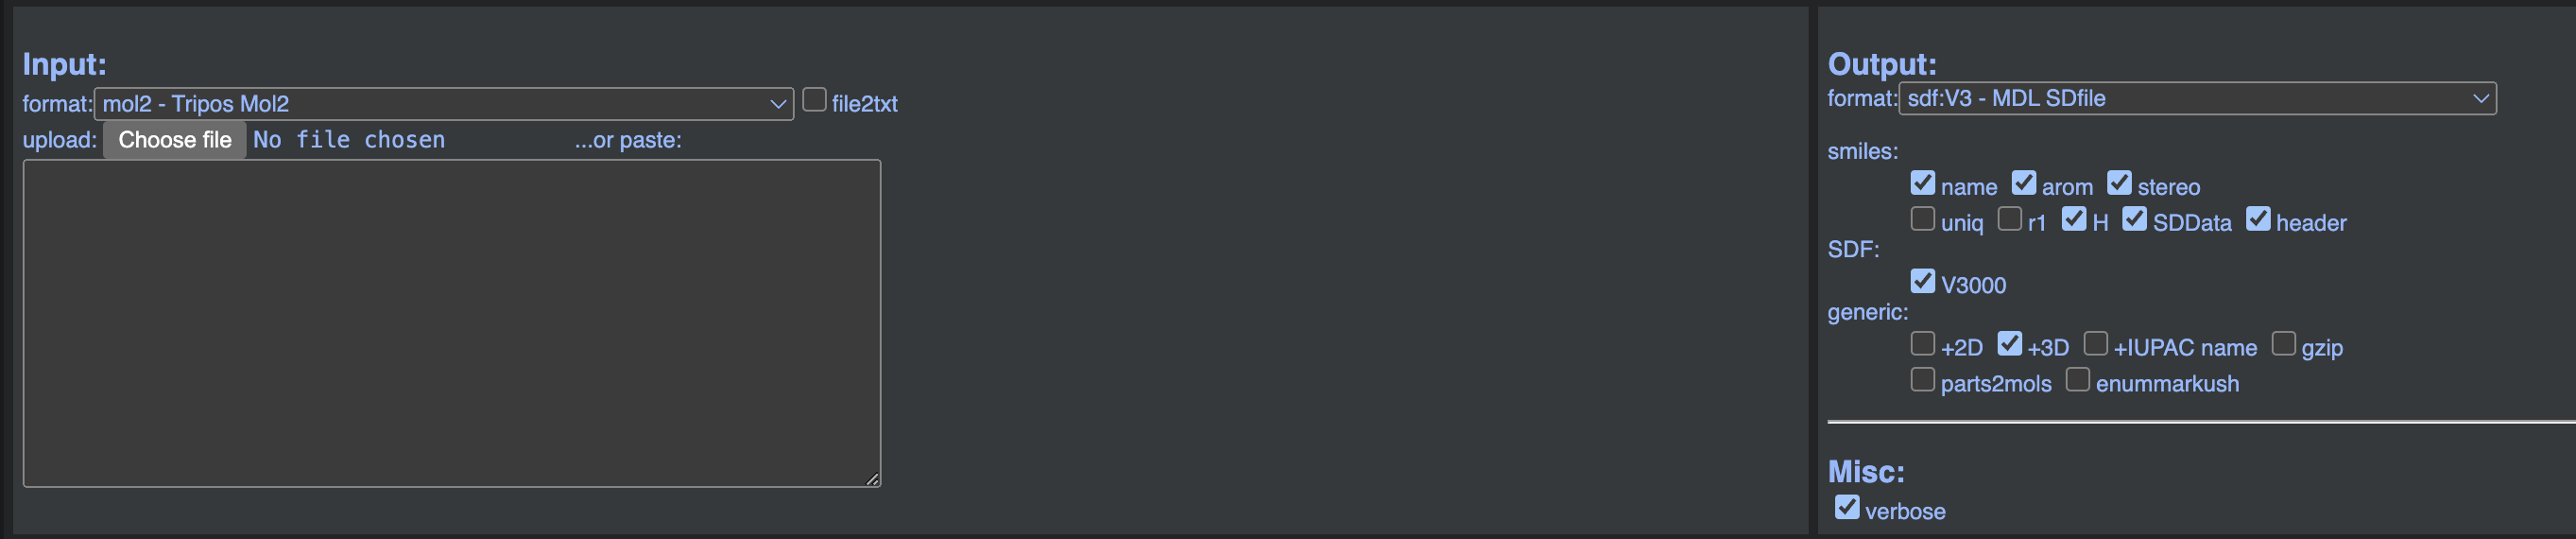

on this website: https://datascience.unm.edu/tomcat/biocomp/convert

In [85]:
sdf_names_2, sdf_mols_2 = custom_sdmolsupplier_H("convert_out.sdf")
# doesn't work

In [86]:
#required me to turn sanitize off in custom_sdmolsupplier_H

sdf_names_2, sdf_mols_2 = custom_sdmolsupplier_H("convert_out.sdf")
# make variable one_mol that is equal to the first value of the first key in sdf_mols, expand to two and three
one_mol_sdf_2 = sdf_mols_2[list(sdf_mols_2.keys())[0]]
two_mol_sdf_2 = sdf_mols_2[list(sdf_mols_2.keys())[1]]
three_mol_sdf_2 = sdf_mols_2[list(sdf_mols_2.keys())[2]]

In [87]:
#but now it cant process the molecule

%%capture captured_output_one_sdf_2
# from rtf2:
import importlib
importlib.reload(rtf2)

# Call TL_lookup on one_mol
rtf2.TL_lookup(one_mol_sdf_2)

print(f"Total XML SMARTS processed: {rtf2.global_XML_smarts_counter}")

# Reset the counter
rtf2.global_XML_smarts_counter = 0

RuntimeError: Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 129 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.5
	BOOST: 1_78


In [84]:
sdf_names_2, sdf_mols_2 = custom_sdmolsupplier_H("convert_out (2).sdf")